In [152]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [153]:
import pandas as pd
import numpy as np

df_2016_17 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2016-17'", con)
df_2017_18 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2017-18'", con)
df_2018_19 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2018-19'", con)
df_2019_20 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2019-20'", con)
df_2020_21 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2020-21'", con)
df_2021_22 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2021-22'", con)
df_2022_23 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2022-23'", con)
df_2023_24 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2023-24'", con)

grad_rate_columns_to_drop = [
    col
    for col in df_2016_17.columns
    if col.startswith("RegHSDiploma") or col.startswith("Dropout")
]
csu_rate_columns_to_drop = [
    col for col in df_2016_17.columns if col.startswith("UniReqs")
]

### Utility functions to graph feature importance over time

In [154]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("default")


def plot_top_k_features(models, model_type, importance_type, target_variable, k=10):
    feature_importances = {}

    for year, model in models.items():
        importance = (
            model["model"].get_booster().get_score(importance_type=importance_type)
        )
        sorted_importance = sorted(
            importance.items(), key=lambda x: x[1], reverse=True
        )[:k]
        feature_importances[year] = {
            feature: score for feature, score in sorted_importance
        }

    df = pd.DataFrame(feature_importances).T.fillna(0)
    mean_importance = df.mean().sort_values(ascending=False)
    top_features = mean_importance.head(k).index.tolist()
    df_top = df[top_features]

    plt.figure(figsize=(14, 6))
    ax = df_top.plot(kind="bar", figsize=(14, 6), width=0.8)

    plt.title(
        f"Top {k} Features by Year for {target_variable} ({model_type}, {importance_type})"
    )
    plt.ylabel("Feature Importance")
    plt.xlabel("Year")
    plt.xticks(rotation=45)
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Return list of top k features across all years
    all_features = []
    for year, features in feature_importances.items():
        all_features.append(pd.Series(features, name=year))

    all_features_df = pd.concat(all_features, axis=1)
    top_features = all_features_df.T.mean(axis=0)
    top_features = top_features.sort_values(ascending=False).head(k)
    return top_features.index.tolist()


def plot_feature_avg_variance(models, model_type, importance_type, target_variable):
    feature_importances = []

    for year, model in models.items():
        importance = (
            model["model"].get_booster().get_score(importance_type=importance_type)
        )
        feature_importances.append(pd.Series(importance))

    df = pd.DataFrame(feature_importances).fillna(0)
    avg_importance = df.mean(axis=0)
    var_importance = df.var(axis=0)

    top_features = avg_importance.sort_values(ascending=False).head(10).index
    avg_top = avg_importance[top_features]
    var_top = var_importance[top_features]

    plt.figure(figsize=(14, 6))

    ax = plt.gca()
    bars = ax.bar(
        range(len(top_features)),
        avg_top,
        yerr=var_top,
        capsize=4,
        color="skyblue",
        label="Average Importance",
    )

    plt.title(
        f"Top {10} Average Feature Importances with Variance for {target_variable} ({model_type}, {importance_type})"
    )
    plt.ylabel("Average Gain Importance")
    plt.xlabel("Features")
    plt.xticks(range(len(top_features)), top_features, rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_feature_time_series(
    models, model_type, importance_type, target_variable, features
):
    feature_importances = {}

    for year, model_dict in models.items():
        importance = (
            model_dict["model"].get_booster().get_score(importance_type="weight")
        )
        feature_importances[year] = {
            feature: importance.get(feature, 0) for feature in features
        }

    df = pd.DataFrame(feature_importances).T
    df.index.name = "Year"

    fig, ax = plt.subplots(figsize=(14, 6))

    markers = ["o", "s", "^", "D", "v", "P", "*", "X", "h", "+"]
    marker_cycle = markers * (len(features) // len(markers) + 1)

    for i, feature in enumerate(features):
        ax.plot(df.index, df[feature], marker=marker_cycle[i], label=feature)

    ax.legend(title="Features", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_title(
        f"Feature Importance Over Time for {target_variable} ({model_type}, {importance_type})"
    )
    ax.set_ylabel("Feature Importance")
    ax.set_xlabel("Year")

    plt.tight_layout()
    plt.show()

### XGBoost

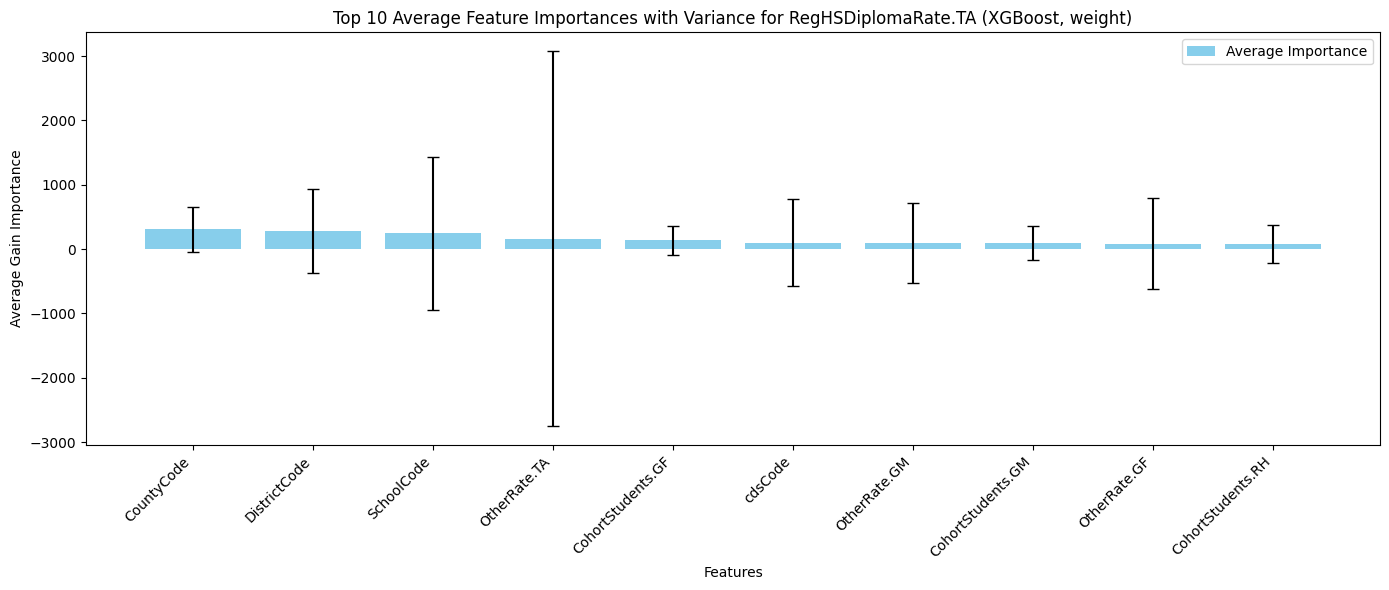

<Figure size 1400x600 with 0 Axes>

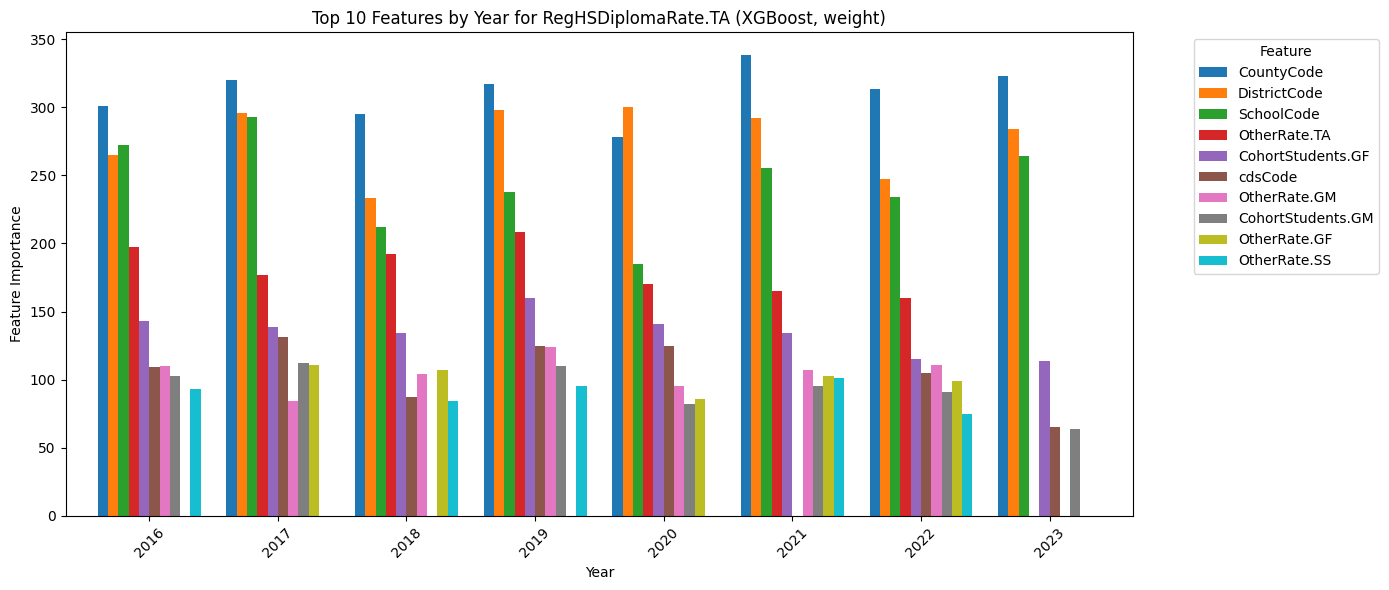

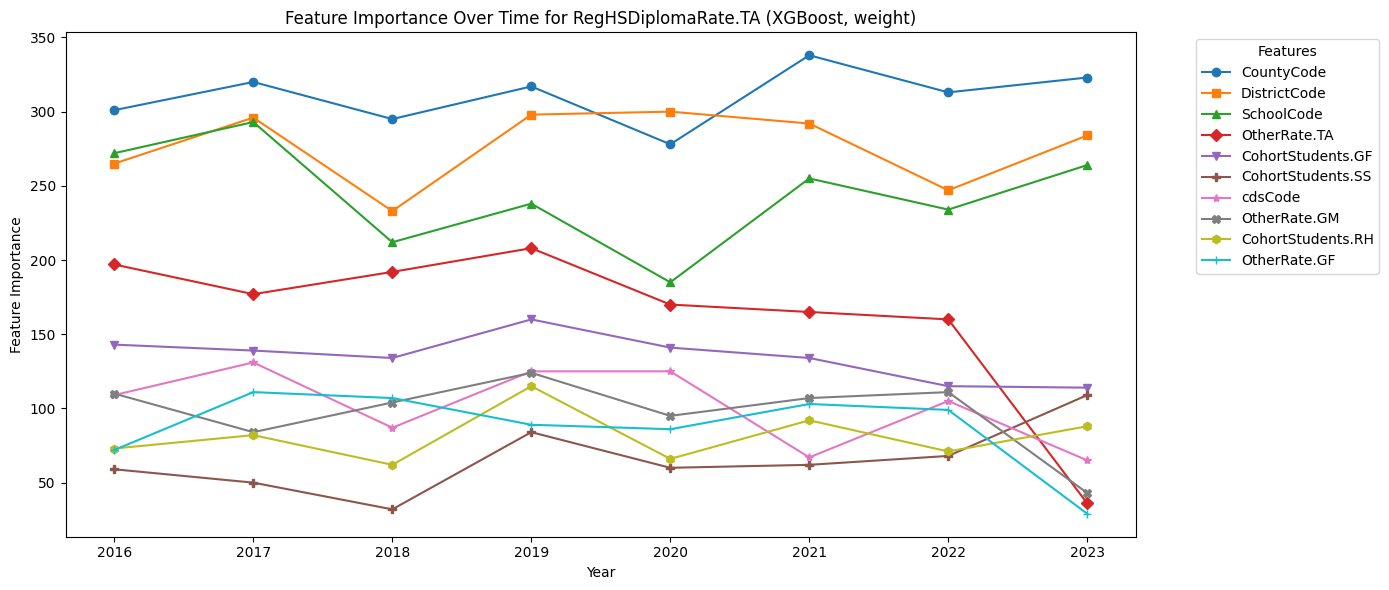

In [155]:
import modeling.utils.xgboost as xgb

grad_rate = "RegHSDiplomaRate.TA"
xgb_model = "XGBoost"

xgb_grad_rate_16_17 = xgb.train_xgboost_model(
    df_2016_17, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
xgb_grad_rate_17_18 = xgb.train_xgboost_model(
    df_2017_18, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
xgb_grad_rate_18_19 = xgb.train_xgboost_model(
    df_2018_19, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
xgb_grad_rate_19_20 = xgb.train_xgboost_model(
    df_2019_20, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
xgb_grad_rate_20_21 = xgb.train_xgboost_model(
    df_2020_21, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
xgb_grad_ratel_21_22 = xgb.train_xgboost_model(
    df_2021_22, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
xgb_grad_rate_22_23 = xgb.train_xgboost_model(
    df_2022_23, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
xgb_grad_rate_23_24 = xgb.train_xgboost_model(
    df_2023_24, grad_rate, grad_rate_columns_to_drop, print_plot=False
)

all_grad_rate_models = {
    2016: xgb_grad_rate_16_17,
    2017: xgb_grad_rate_17_18,
    2018: xgb_grad_rate_18_19,
    2019: xgb_grad_rate_19_20,
    2020: xgb_grad_rate_20_21,
    2021: xgb_grad_ratel_21_22,
    2022: xgb_grad_rate_22_23,
    2023: xgb_grad_rate_23_24,
}

plot_feature_avg_variance(all_grad_rate_models, xgb_model, "weight", grad_rate)
top_k_features = plot_top_k_features(
    all_grad_rate_models, xgb_model, "weight", grad_rate, k=10
)
plot_feature_time_series(
    all_grad_rate_models, xgb_model, "weight", grad_rate, top_k_features
)

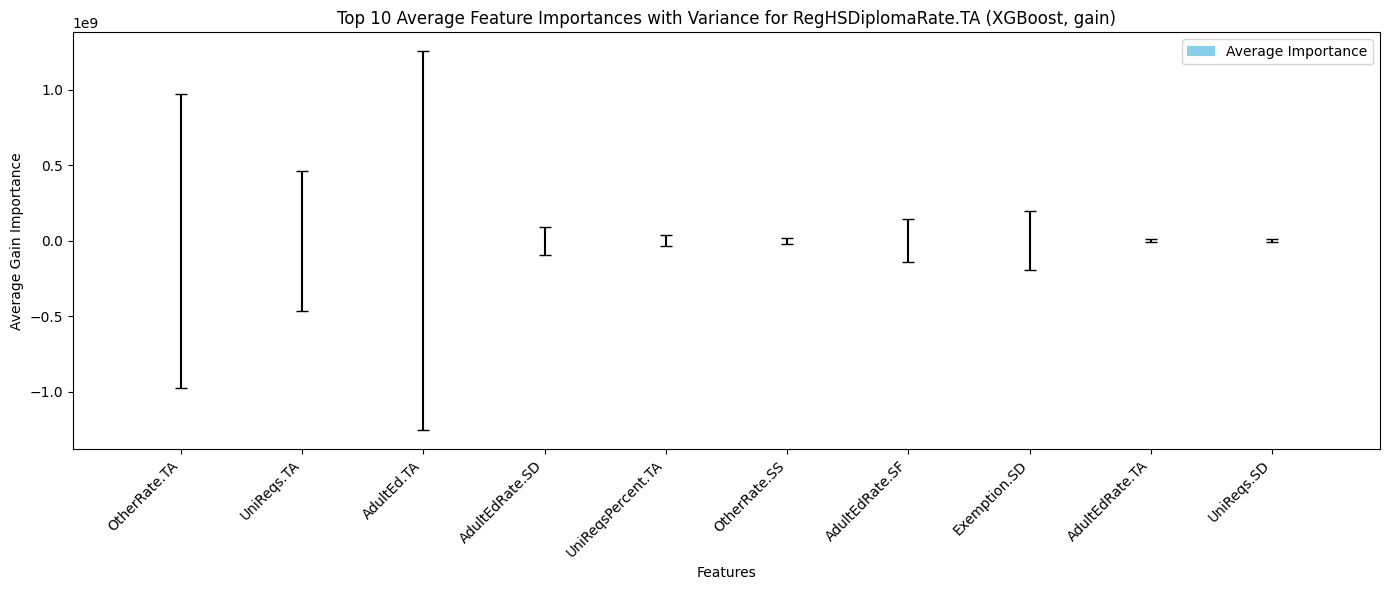

<Figure size 1400x600 with 0 Axes>

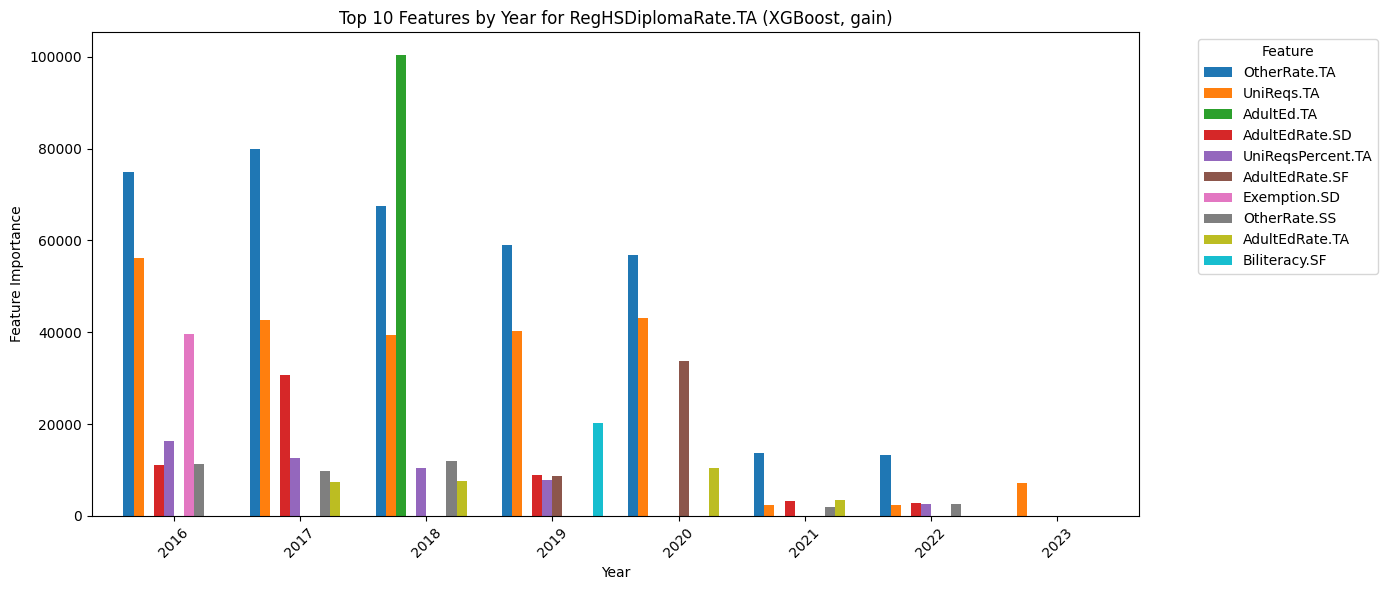

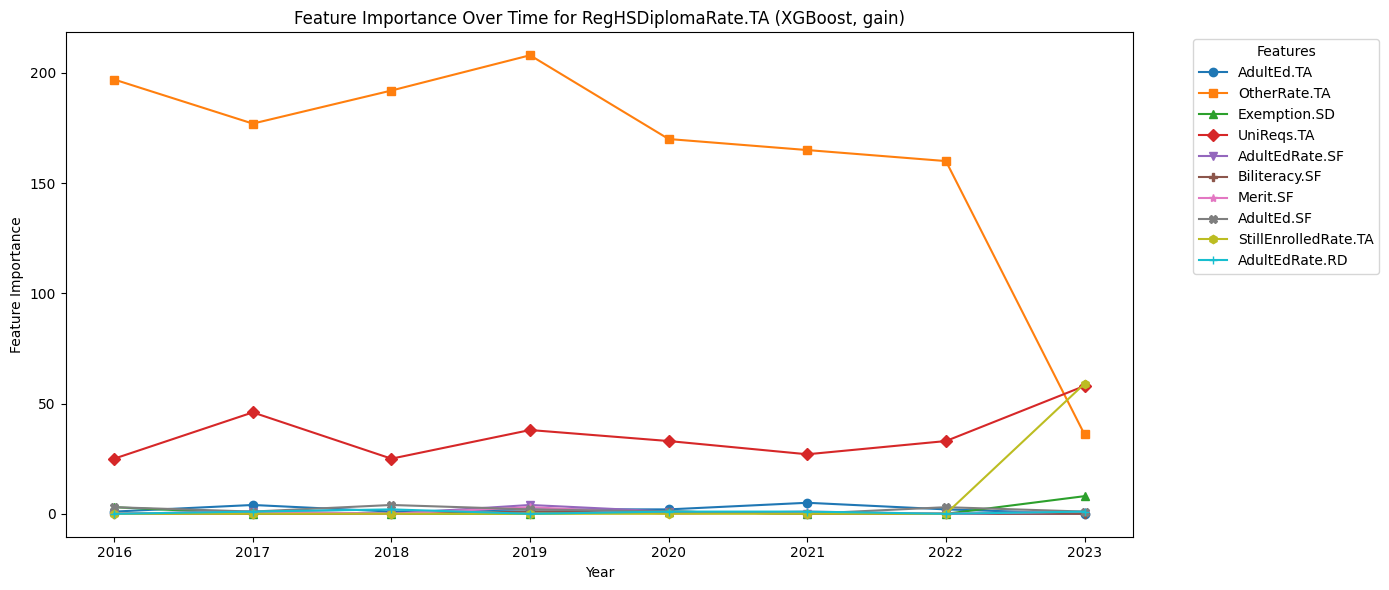

In [156]:
plot_feature_avg_variance(all_grad_rate_models, xgb_model, "gain", grad_rate)
top_k_features = plot_top_k_features(
    all_grad_rate_models, xgb_model, "gain", grad_rate, k=10
)
plot_feature_time_series(
    all_grad_rate_models, xgb_model, "gain", grad_rate, top_k_features
)

In [157]:
def plot_rf_feature_avg_variance(models, model_type, target_variable):
    feature_importances = []

    for year, model_dict in models.items():
        rf_model = model_dict["model"]
        importance = rf_model.feature_importances_
        feature_importances.append(pd.Series(importance))

    df = pd.DataFrame(feature_importances).fillna(0)
    avg_importance = df.mean(axis=0)
    var_importance = df.var(axis=0)

    top_features = avg_importance.sort_values(ascending=False).head(10).index
    avg_top = avg_importance[top_features]
    var_top = var_importance[top_features]

    plt.figure(figsize=(14, 6))
    avg_top.plot(
        kind="bar", yerr=var_top, capsize=4, color="skyblue", label="Average Importance"
    )

    for i, feature in enumerate(top_features):
        plt.scatter(
            [i],
            [avg_top[feature]],
            color="blue",
            zorder=5,
            label="Actual Value" if i == 0 else None,
        )

    plt.title(
        f"Top {10} Average Feature Importances with Variance for {target_variable} ({model_type})"
    )
    plt.ylabel("Average Gain Importance")
    plt.xlabel("Features")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_top_k_features_rf(models, model_type, target_variable, feature_names, k=10):
    feature_importances = {}

    for year, model_dict in models.items():
        model = model_dict["model"]
        scores = dict(zip(feature_names, model.feature_importances_))
        feature_importances[year] = scores

    df = pd.DataFrame(feature_importances).T.fillna(0)
    mean_importance = df.mean().sort_values(ascending=False)
    top_features = mean_importance.head(k).index.tolist()
    df_top = df[top_features]

    plt.figure(figsize=(14, 6))
    ax = df_top.plot(kind="bar", figsize=(14, 6), width=0.8)

    plt.title(f"Top {k} Features by Year for {target_variable} ({model_type})")
    plt.ylabel("Feature Importance")
    plt.xlabel("Year")
    plt.xticks(rotation=45)
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Return list of top k features across all years
    all_features_df = pd.DataFrame(feature_importances).T
    top_features = all_features_df.mean().sort_values(ascending=False).head(k)
    return top_features.index.tolist()


def plot_feature_time_series_rf(
    models, model_type, target_variable, features, feature_names
):
    feature_importances = {}

    for year, model_dict in models.items():
        model = model_dict["model"]
        importance = dict(zip(feature_names, model.feature_importances_))
        feature_importances[year] = {
            feature: importance.get(feature, 0) for feature in features
        }

    df = pd.DataFrame(feature_importances).T
    df.index.name = "Year"

    fig, ax = plt.subplots(figsize=(14, 6))

    markers = ["o", "s", "^", "D", "v", "P", "*", "X", "h", "+"]
    marker_cycle = markers * (len(features) // len(markers) + 1)

    for i, feature in enumerate(features):
        ax.plot(df.index, df[feature], marker=marker_cycle[i], label=feature)

    ax.legend(title="Features", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_title(f"Feature Importance Over Time for {target_variable} ({model_type})")
    ax.set_ylabel("Feature Importance")
    ax.set_xlabel("Year")

    plt.tight_layout()
    plt.show()

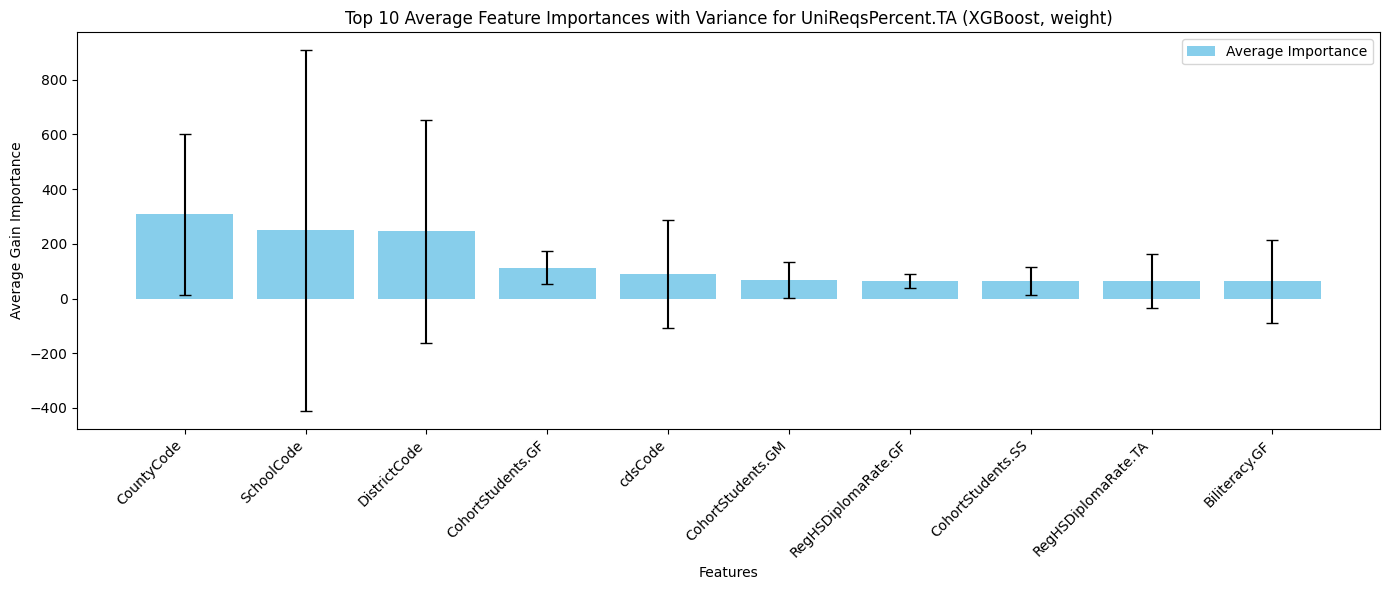

<Figure size 1400x600 with 0 Axes>

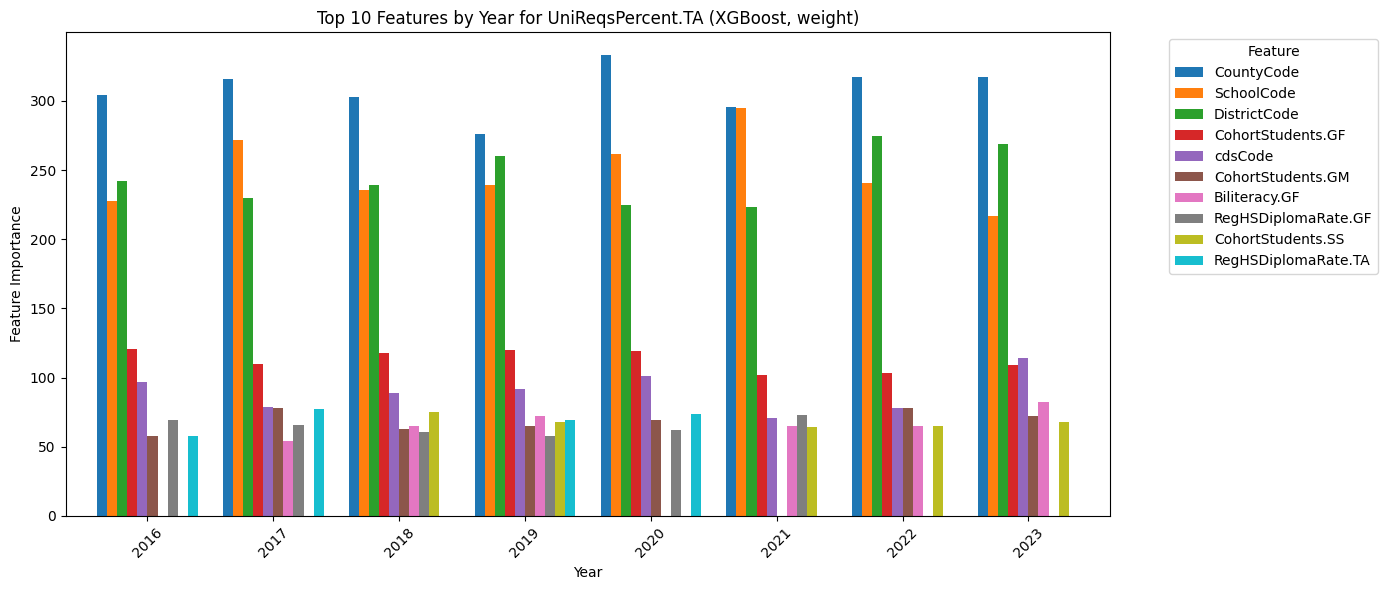

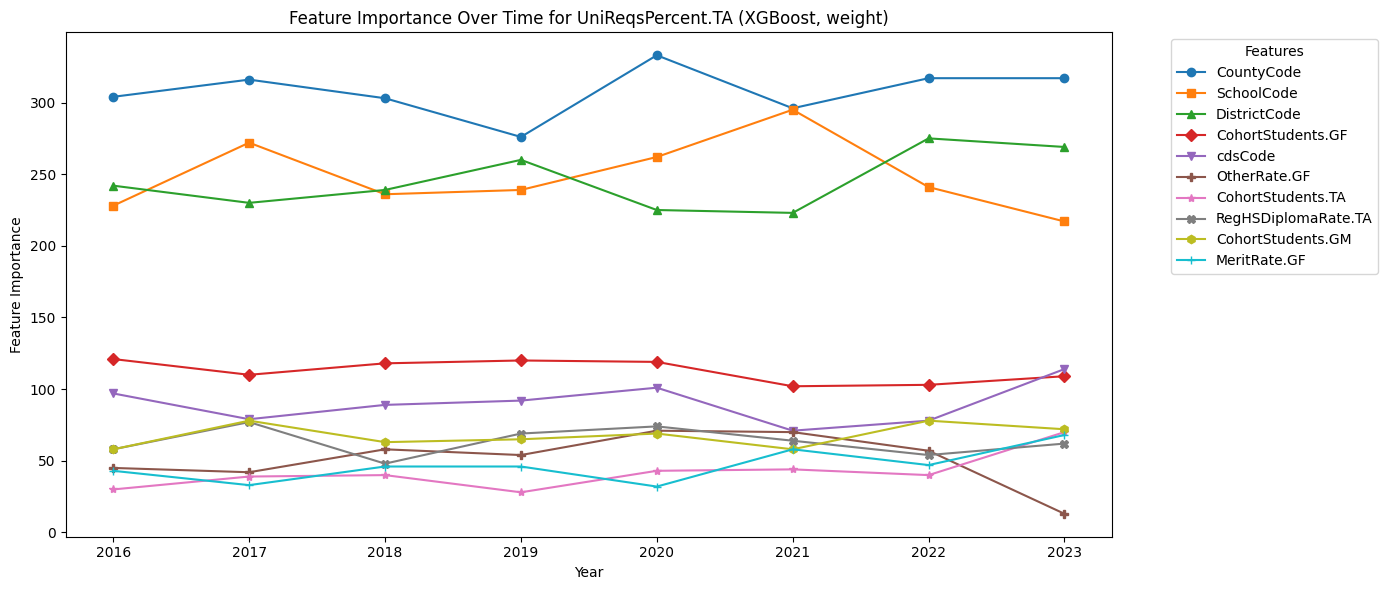

In [158]:
uc_csu_rate = "UniReqsPercent.TA"
xgb_csu_rate_16_17 = xgb.train_xgboost_model(
    df_2016_17, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
xgb_csu_rate_17_18 = xgb.train_xgboost_model(
    df_2017_18, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
xgb_csu_rate_18_19 = xgb.train_xgboost_model(
    df_2018_19, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
xgb_csu_rate_19_20 = xgb.train_xgboost_model(
    df_2019_20, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
xgb_csu_rate_20_21 = xgb.train_xgboost_model(
    df_2020_21, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
xgb_csu_rate_21_22 = xgb.train_xgboost_model(
    df_2021_22, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
xgb_csu_rate_22_23 = xgb.train_xgboost_model(
    df_2022_23, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
xgb_csu_rate_23_24 = xgb.train_xgboost_model(
    df_2023_24, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)

all_csu_rate_models = {
    2016: xgb_csu_rate_16_17,
    2017: xgb_csu_rate_17_18,
    2018: xgb_csu_rate_18_19,
    2019: xgb_csu_rate_19_20,
    2020: xgb_csu_rate_20_21,
    2021: xgb_csu_rate_21_22,
    2022: xgb_csu_rate_22_23,
    2023: xgb_csu_rate_23_24,
}

plot_feature_avg_variance(all_csu_rate_models, xgb_model, "weight", uc_csu_rate)
top_k_features = plot_top_k_features(
    all_csu_rate_models, xgb_model, "weight", uc_csu_rate, k=10
)
plot_feature_time_series(
    all_csu_rate_models, xgb_model, "weight", uc_csu_rate, top_k_features
)

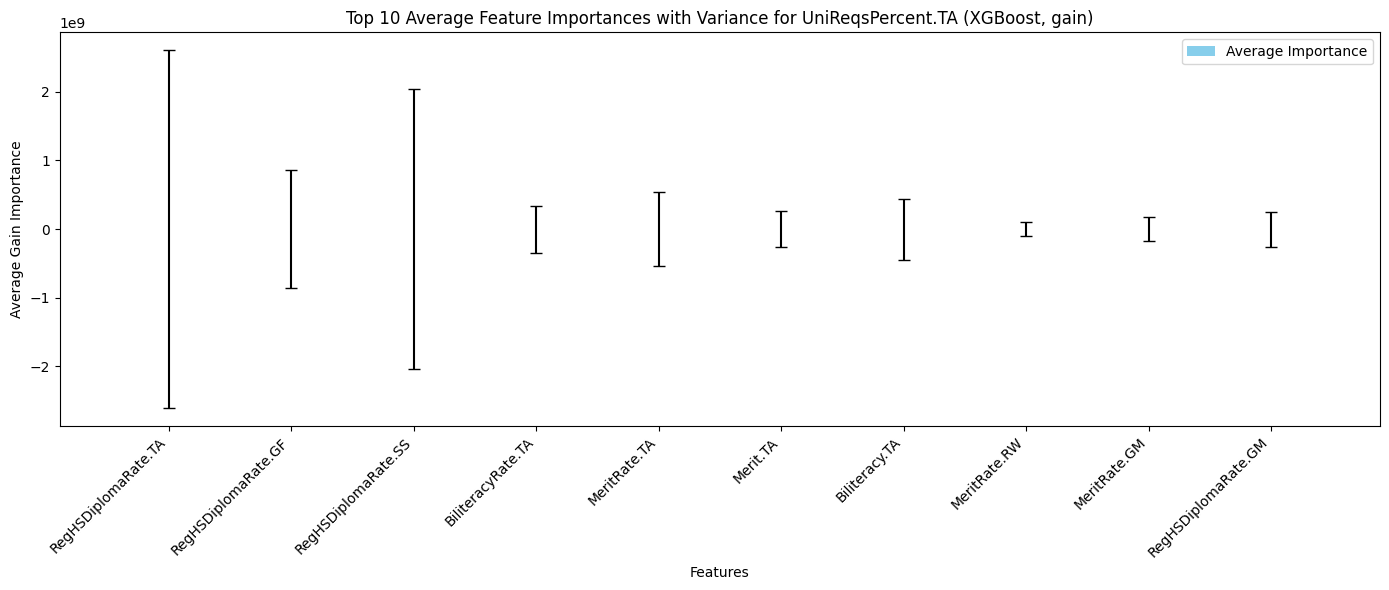

<Figure size 1400x600 with 0 Axes>

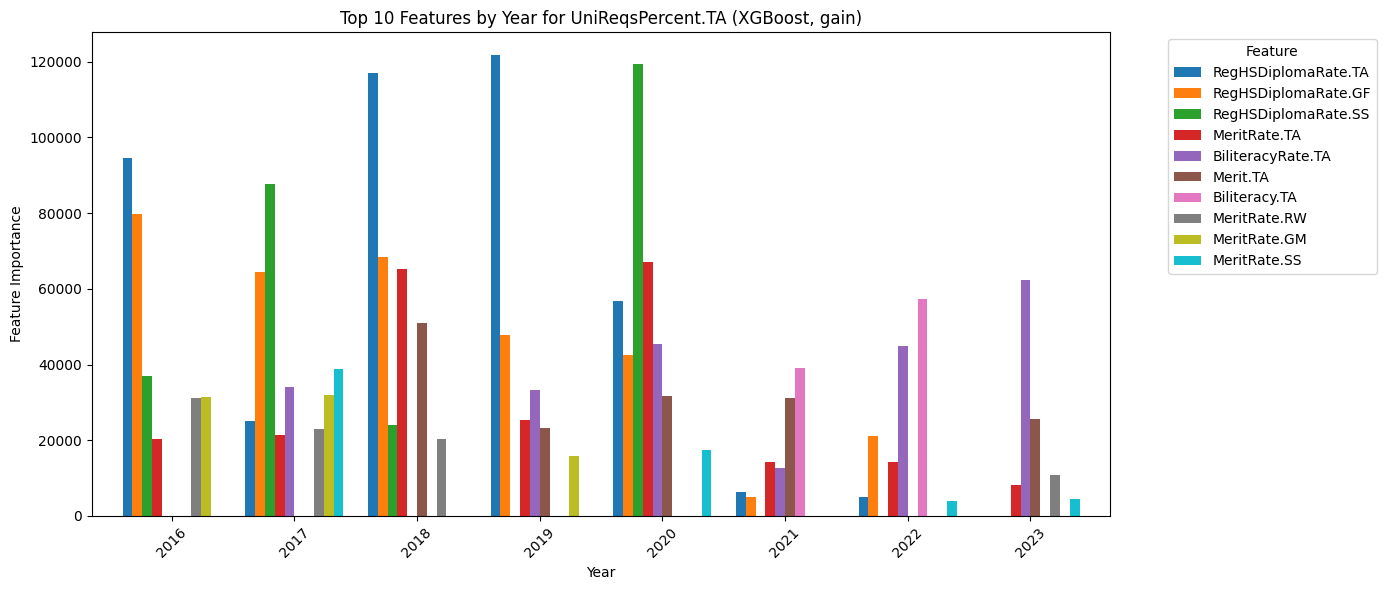

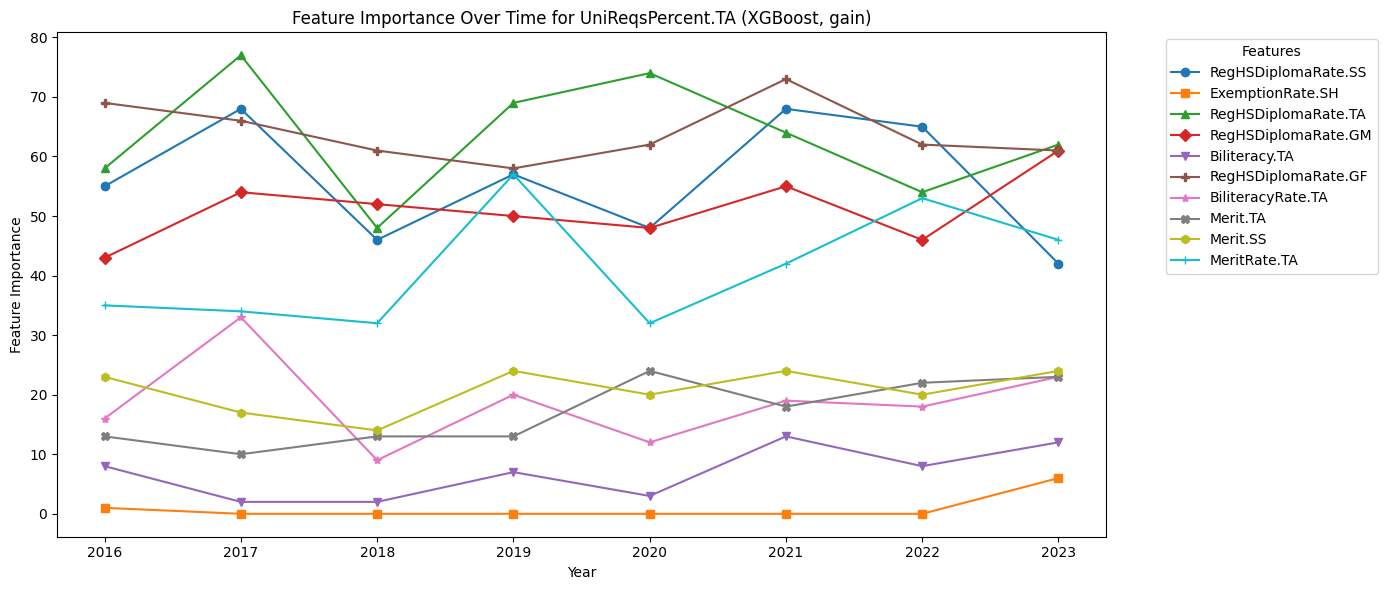

In [159]:
plot_feature_avg_variance(all_csu_rate_models, xgb_model, "gain", uc_csu_rate)
top_k_features = plot_top_k_features(
    all_csu_rate_models, xgb_model, "gain", uc_csu_rate, k=10
)
plot_feature_time_series(
    all_csu_rate_models, xgb_model, "gain", uc_csu_rate, top_k_features
)

### Random Forest

In [ ]:
def plot_top_k_features_rf(models, model_type, target_variable, feature_names, k=10):
    feature_importances = {}

    for year, model_dict in models.items():
        model = model_dict["model"]
        scores = dict(zip(feature_names, model.feature_importances_))
        feature_importances[year] = scores

    df = pd.DataFrame(feature_importances).T.fillna(0)
    mean_importance = df.mean().sort_values(ascending=False)
    top_features = mean_importance.head(k).index.tolist()
    df_top = df[top_features]

    plt.figure(figsize=(14, 6))
    ax = df_top.plot(kind="bar", figsize=(14, 6), width=0.8)

    plt.title(f"Top {k} Features by Year for {target_variable} ({model_type})")
    plt.ylabel("Feature Importance")
    plt.xlabel("Year")
    plt.xticks(rotation=45)
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
 
    return top_features.tolist()


def plot_feature_avg_variance_rf(models, model_type, target_variable, feature_names):
    feature_importances = []

    for year, model_dict in models.items():
        model = model_dict["model"]
        importance = pd.Series(model.feature_importances_, index=feature_names)
        feature_importances.append(importance)

    df = pd.DataFrame(feature_importances).fillna(0)
    avg_importance = df.mean(axis=0)
    var_importance = df.var(axis=0)

    top_features = avg_importance.sort_values(ascending=False).head(10).index
    avg_top = avg_importance[top_features]
    var_top = var_importance[top_features]

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    bars = ax.bar(
        range(len(top_features)),
        avg_top,
        yerr=var_top,
        capsize=4,
        color="skyblue",
        label="Average Importance",
    )

    plt.title(
        f"Top {10} Average Feature Importances with Variance for {target_variable} ({model_type})"
    )
    plt.ylabel("Average Feature Importance")
    plt.xlabel("Features")
    plt.xticks(range(len(top_features)), top_features, rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_feature_time_series_rf(
    models, model_type, target_variable, features, feature_names
):
    feature_importances = {}

    for year, model_dict in models.items():
        model = model_dict["model"]
        importance = dict(zip(feature_names, model.feature_importances_))
        feature_importances[year] = {
            feature: importance.get(feature, 0) for feature in features
        }

    df = pd.DataFrame(feature_importances).T
    df.index.name = "Year"

    fig, ax = plt.subplots(figsize=(14, 6))

    markers = ["o", "s", "^", "D", "v", "P", "*", "X", "h", "+"]
    marker_cycle = markers * (len(features) // len(markers) + 1)

    for i, feature in enumerate(features):
        ax.plot(df.index, df[feature], marker=marker_cycle[i], label=feature)

    ax.legend(title="Features", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_title(f"Feature Importance Over Time for {target_variable} ({model_type})")
    ax.set_ylabel("Feature Importance")
    ax.set_xlabel("Year")

    plt.tight_layout()
    plt.show()

In [161]:
import modeling.utils.randomforest as rf

rf_grad_rate_16_17 = rf.train_random_forest_model(
    df_2016_17, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
rf_grad_rate_17_18 = rf.train_random_forest_model(
    df_2017_18, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
rf_grad_rate_18_19 = rf.train_random_forest_model(
    df_2018_19, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
rf_grad_rate_19_20 = rf.train_random_forest_model(
    df_2019_20, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
rf_grad_rate_20_21 = rf.train_random_forest_model(
    df_2020_21, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
rf_grad_rate_21_22 = rf.train_random_forest_model(
    df_2021_22, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
rf_grad_rate_22_23 = rf.train_random_forest_model(
    df_2022_23, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
rf_grad_rate_23_24 = rf.train_random_forest_model(
    df_2023_24, grad_rate, grad_rate_columns_to_drop, print_plot=False
)
rf_grad_rate_models = {
    2016: rf_grad_rate_16_17,
    2017: rf_grad_rate_17_18,
    2018: rf_grad_rate_18_19,
    2019: rf_grad_rate_19_20,
    2020: rf_grad_rate_20_21,
    2021: rf_grad_rate_21_22,
    2022: rf_grad_rate_22_23,
    2023: rf_grad_rate_23_24,
}

plot_feature_avg_variance_rf(
    rf_grad_rate_models, "Random Forest", grad_rate, grad_rate_columns_to_drop
)
top_k_features = plot_top_k_features_rf(
    rf_grad_rate_models,
    "Random Forest",
    grad_rate,
    grad_rate_columns_to_drop,
    k=10,
)
plot_feature_time_series_rf(
    rf_grad_rate_models,
    "Random Forest",
    grad_rate,
    top_k_features,
    grad_rate_columns_to_drop,
)

ValueError: Length of values (346) does not match length of index (76)

In [ ]:
rf_csu_rate_16_17 = rf.train_random_forest_model(
    df_2016_17, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
rf_csu_rate_17_18 = rf.train_random_forest_model(
    df_2017_18, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
rf_csu_rate_18_19 = rf.train_random_forest_model(
    df_2018_19, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
rf_csu_rate_19_20 = rf.train_random_forest_model(
    df_2019_20, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
rf_csu_rate_20_21 = rf.train_random_forest_model(
    df_2020_21, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
rf_csu_rate_21_22 = rf.train_random_forest_model(
    df_2021_22, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
rf_csu_rate_22_23 = rf.train_random_forest_model(
    df_2022_23, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
rf_csu_rate_23_24 = rf.train_random_forest_model(
    df_2023_24, uc_csu_rate, csu_rate_columns_to_drop, print_plot=False
)
rf_csu_rate_models = {
    2016: rf_csu_rate_16_17,
    2017: rf_csu_rate_17_18,
    2018: rf_csu_rate_18_19,
    2019: rf_csu_rate_19_20,
    2020: rf_csu_rate_20_21,
    2021: rf_csu_rate_21_22,
    2022: rf_csu_rate_22_23,
    2023: rf_csu_rate_23_24,
}

plot_feature_avg_variance_rf(
    rf_csu_rate_models, "Random Forest", uc_csu_rate, csu_rate_columns_to_drop
)

top_k_features = plot_top_k_features_rf(
    rf_csu_rate_models,
    "Random Forest",
    uc_csu_rate,
    csu_rate_columns_to_drop,
    k=10,
)

plot_feature_time_series_rf(
    rf_csu_rate_models,
    "Random Forest",
    uc_csu_rate,
    top_k_features,
    csu_rate_columns_to_drop,
)

In [ ]:
con.close()